In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import dataset

In [2]:
df_player_profile = pd.read_csv('./tennis_profile.csv', sep=',', index_col=0)

We start by dropping three attributes we're sure we can't use in the classification task

In [3]:
df_profile_clone = df_player_profile.drop(columns=['player_id', 'player_name', 'player_ht']) 

Since 'mc_entry' has roughly 1/5 of null values, we fill them with the most common value.

We also noted that 'SvGms' has a null value for most of the unskilled players. We decided to set it to 0.

In [4]:
df_profile_clone['mc_entry'] = df_profile_clone['mc_entry'].fillna(df_profile_clone['mc_entry'].value_counts().idxmax())

df_profile_clone['SvGms'] = df_profile_clone['SvGms'].fillna(0)

# Mapping


Let's start by defining a function that allows us to map categorical values into numerical ones.

In [5]:
#input: the dataset and the list of variables' names to integer-map
def mapping_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [6]:
variables = ['fvrt_level', 'player_hand', 'mc_entry']
df_profile_clone = mapping_data(df_profile_clone, variables)

# Correlation

We don't consider for the correlation analysis the attributes that we'll use to compute the labels.

In [7]:
df_lost_attr = df_profile_clone.drop(columns=['first_serv_rt', 'fvrt_level', 'perc_bs', 'highest_scr', 'avg_scr'], axis=1)

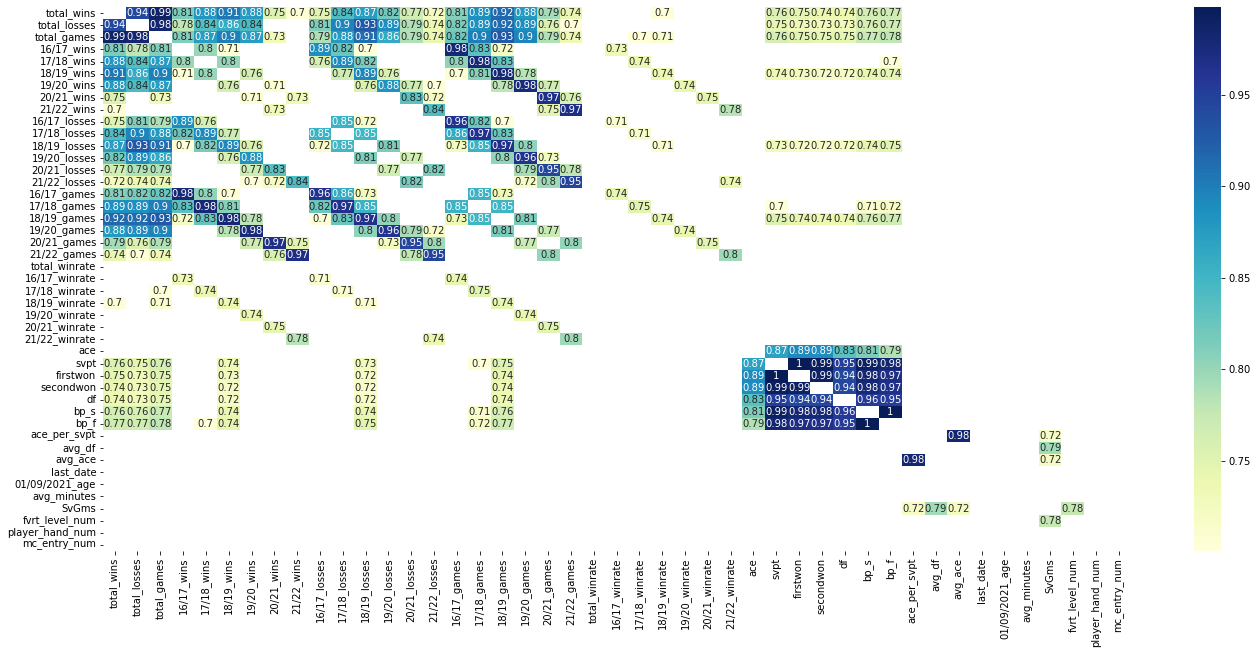

In [8]:
corr = df_lost_attr.corr()
kot = corr[((corr>=.7) | (corr<=-0.7)) & (corr!=1.0)]
plt.figure(figsize=(23,10))
sns.heatmap(kot, annot=True, cmap="YlGnBu")
plt.show()

We remove the most correlated attributes, trying to keep a sufficient large amount of attributes to proceed with the classification.

In [9]:
df_profile_clone = df_profile_clone.drop(['total_wins', 'total_losses', 'total_games', '16/17_losses', '17/18_losses',
                                    '18/19_losses', '19/20_losses', '20/21_losses', '16/17_games', '17/18_games',
                                    '18/19_games', '19/20_games', '20/21_games', '21/22_games', 'total_winrate',
                                    '16/17_winrate', '17/18_winrate', '18/19_winrate', '19/20_winrate', 
                                    '20/21_winrate', '21/22_losses', '21/22_winrate', 'firstwon', 'secondwon', 'bp_s', 'bp_f', 'last_date',
                                   'avg_ace', 'avg_minutes', 'df'], axis=1)
df1 = df_profile_clone.drop(['first_serv_rt', 'fvrt_level', 'perc_bs', 'highest_scr', 'avg_scr'], axis=1)

As we can see below, the resulting dataframe has a much better correlation spread between its attributes.

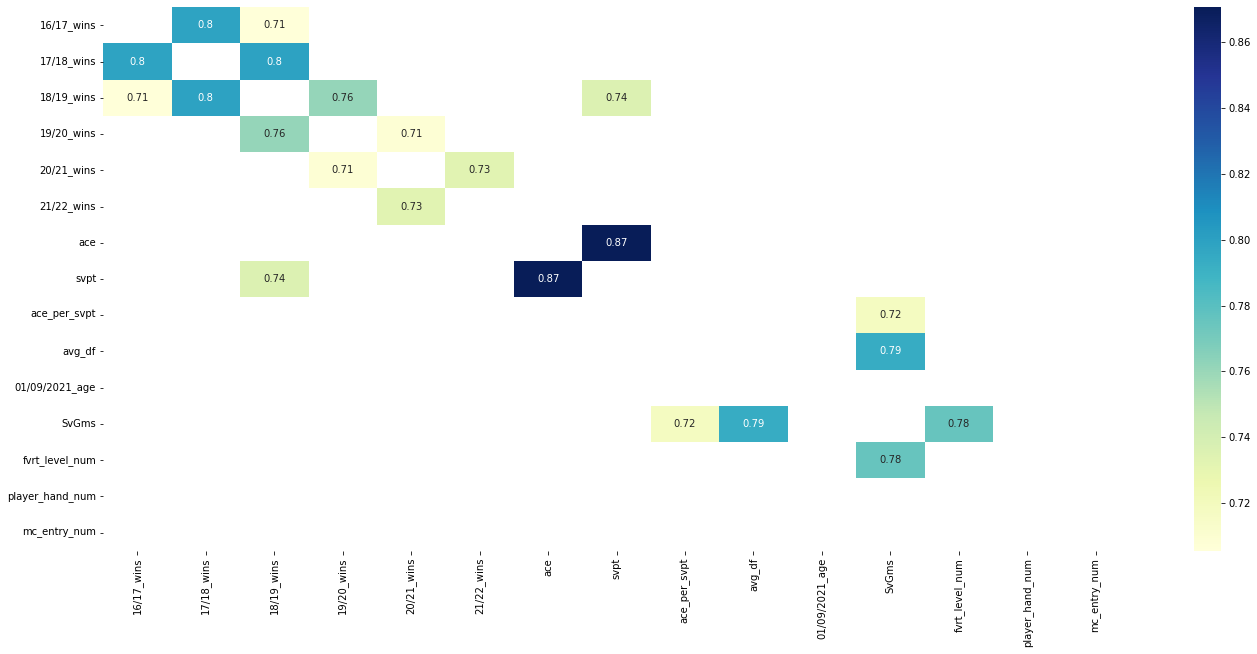

In [10]:
corr = df1.corr()
kot = corr[((corr>=.7) | (corr<=-0.7)) & (corr!=1.0)]
plt.figure(figsize=(23,10))
sns.heatmap(kot, annot=True, cmap="YlGnBu")
plt.show()

# Labels

In [11]:
#function to compute the label for the high or low rank players
#input: record that corresponds to the player
#return: integer that represents the label computed, 0 = low rank and 1 = high rank
def computingLabel(row):
    label = 0
    if row['fvrt_level'] != 'S' or row['fvrt_level'] != 'F' or row['fvrt_level'] != '10' or row['fvrt_level'] != '15' or row['fvrt_level'] != '25' or row['fvrt_level'] != '50' or row['fvrt_level'] != '60' or row['fvrt_level'] != 'A':
        if row['highest_scr'] >= 150 and row['avg_scr']  >= 75: #check if the highest and the average score is greater or equal to the threshold
            if row['first_serv_rt'] >= 0.55 or row['perc_bs'] >= 0.2: #check if player stats (first_serv_rt, perc_bs) is greater or equal to threshold
                label = 1
    
    if row['highest_scr'] >= 250 and row['avg_scr'] >= 125:
        if row['first_serv_rt'] >= 0.65 or row['perc_bs'] >= 0.3:
            label = 1
            
    return label

In [12]:
label_to_add = []
for index, row in df_profile_clone.iterrows():
    label_to_add.append(computingLabel(row))

df_profile_clone['label'] = label_to_add

Let's check how many high ranking players we got:

In [13]:
np.sum(label_to_add)

1135

In [14]:
df_profile_clone['label'].value_counts()

0    8939
1    1135
Name: label, dtype: int64

In [15]:
#drop the categorical variables since we don't need them anymore 
df_profile_clone.drop(columns=['fvrt_level', 'player_hand', 'mc_entry'], axis=1, inplace=True)

# Classification

## Decision Tree

We first need to split the dataset into train and test dataset. 

We have deleted the attributes that we used to compute the label because the decision tree would have been too simple if we had left them in. 

On the contrary, if we drop these features the model becomes more complex than the previous one.

In [16]:
from sklearn.model_selection import train_test_split

df_copy = df_profile_clone.copy()
print(df_copy.info())

label = df_profile_clone.pop('label')
df_profile_tree = df_profile_clone.copy() #copy dataframe in a temporary dataframe for decision tree
df_profile_tree.drop(['highest_scr', 'avg_scr', 'perc_bs', 'first_serv_rt', 'fvrt_level_num'], axis=1, inplace=True) #drop features that we used to compute the label
train_set, test_set, train_label, test_label = train_test_split(df_profile_tree, label, stratify=label, test_size=0.30)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10074 entries, 0 to 10073
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   16/17_wins       10074 non-null  int64  
 1   17/18_wins       10074 non-null  int64  
 2   18/19_wins       10074 non-null  int64  
 3   19/20_wins       10074 non-null  int64  
 4   20/21_wins       10074 non-null  int64  
 5   21/22_wins       10074 non-null  int64  
 6   ace              10074 non-null  int64  
 7   svpt             10074 non-null  int64  
 8   ace_per_svpt     10074 non-null  float64
 9   first_serv_rt    10074 non-null  float64
 10  avg_df           10074 non-null  float64
 11  01/09/2021_age   10074 non-null  float64
 12  perc_bs          10074 non-null  float64
 13  highest_scr      10074 non-null  int64  
 14  avg_scr          10074 non-null  float64
 15  SvGms            10074 non-null  float64
 16  fvrt_level_num   10074 non-null  int64  
 17  player_hand_

First, we have used the random strategy splitter, with min_samples_split equal to __4__ and min_samples_leaf equal to __6__, because we have seen that it is the best possible result that we have tested.

In [17]:
#define a decision tree and fit it using a splitter strategy - 'random'
from sklearn import tree
dtree = tree.DecisionTreeClassifier(criterion='gini', splitter='random', 
                                  max_depth=12, 
                                  min_samples_split=4, min_samples_leaf=6)
dtree = dtree.fit(train_set, train_label)

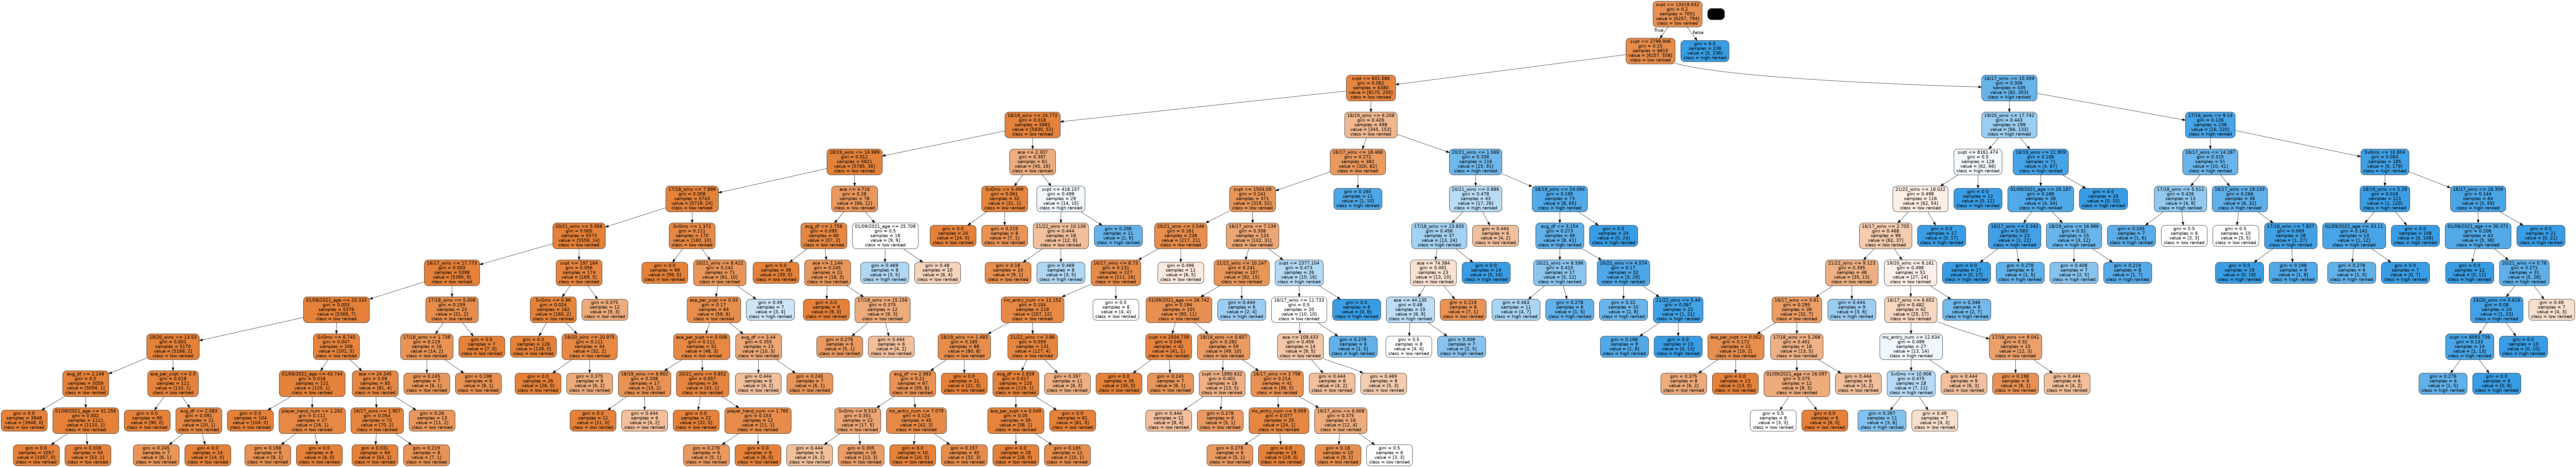

In [18]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dtree, out_file=None, 
                        feature_names=list(train_set.columns),  
                       class_names=['low ranked', 'high ranked'],  
                       filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [19]:
#predict using the decision tree
#the predict function returns the actual predicted labels
train_pred_dt = dtree.predict(train_set)
test_pred_dt = dtree.predict(test_set)

In [20]:
#evaluate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9800028364770954
Accuracy test set  0.9679126695335759
Precision train set  0.979668554682489
Recall train set  0.9800028364770954
F1 score train set  0.9796639373806408
Support train set  (array([0.98416719, 0.94421769]), array([0.99344734, 0.87405542]), array([0.98878549, 0.90778286]), array([6257,  794]))


There we can see the accuracy of the train and test set are so quite similar. THerefore, the model doesn't suffer from overfitting, since the accuracy is pretty good, it doesn't suffer also from underfitting. 

In [21]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['low ranked', 'high ranked']))

In [22]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  low ranked       0.98      0.99      0.98      2682
 high ranked       0.90      0.81      0.85       341

    accuracy                           0.97      3023
   macro avg       0.94      0.90      0.92      3023
weighted avg       0.97      0.97      0.97      3023



In detail, we can see that the precision is smaller on the high-ranked label compared to the low-ranked

In [23]:
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dtree, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.004219849904378255
Score time  0.001382748285929362
Test score  0.969224262498831
Train score  0.9791518931387769


The confusion matrix shows that there are about __50__ false positives and about __50__ false negatives (These are the averages of these values, we executed the code many times in order to compute the average of these values). So, it means that there are __50__ high-ranked players that are recognized as low-ranked players. Indeed, this result clarifies the smaller precision on the "high-ranked" label.
However __280__ were correctly classified as good players.

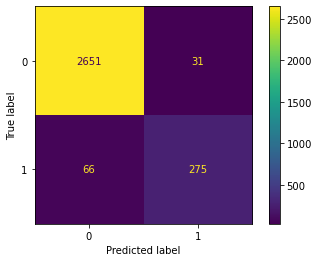

In [24]:
#plotting the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(dtree, test_set, test_label)
plt.show() 

In this part, we have tested the 'best' strategy splitter, with the same parameters.

In [25]:
#using with different splitter strategy - 'best'
dtree_best = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=12, 
                                  min_samples_split=4, min_samples_leaf=6)
dtree_best = dtree.fit(train_set, train_label)

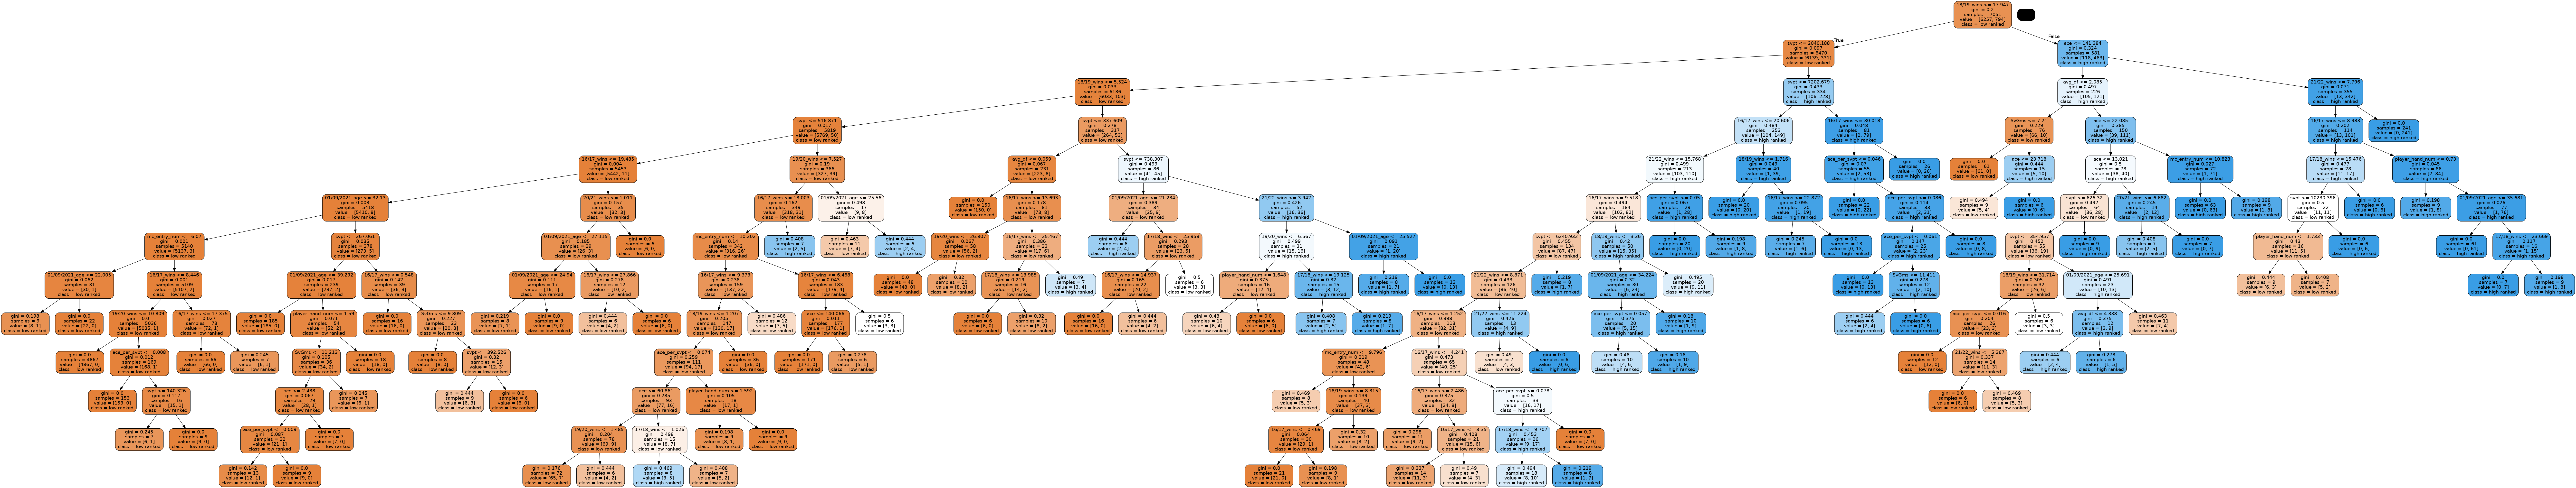

In [26]:
dot_data = tree.export_graphviz(dtree_best, out_file=None, 
                        feature_names=list(train_set.columns),  
                       class_names=['low ranked', 'high ranked'],  
                       filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [27]:
#predict using the decision tree
#the predict function returns the actual predicted labels
train_pred_dt = dtree_best.predict(train_set)
test_pred_dt = dtree_best.predict(test_set)

In [28]:
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9804283080414126
Accuracy test set  0.9705590473040027
Precision train set  0.9801739865845669
Recall train set  0.9804283080414126
F1 score train set  0.9802520166234452
Support train set  (array([0.98648434, 0.93044619]), array([0.99152949, 0.8929471 ]), array([0.98900048, 0.91131105]), array([6257,  794]))


The accuracy of this model is very similar to the previous one (random splitter), hence the results of the two models are similar.

In [29]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  low ranked       0.98      0.99      0.98      2682
 high ranked       0.89      0.84      0.87       341

    accuracy                           0.97      3023
   macro avg       0.93      0.92      0.92      3023
weighted avg       0.97      0.97      0.97      3023



Even in this case we have some issue on the accuracy of the high-ranked players, despite that, the results are pretty good.

In [30]:
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dtree_best, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.0036797523498535156
Score time  0.001367807388305664
Test score  0.9679478477545393
Train score  0.9759608714608783


In this case, the confusion matrix shows a slightly better result, as we expected. We have achieved about __40__ false negatives and about __50__ false positives.

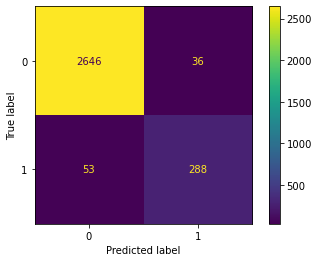

In [31]:
#plotting the confusion matrix 
plot_confusion_matrix(dtree_best, test_set, test_label)
plt.show() 

After comparing the two decision trees, we have concluded that, in the most cases, the 'best' strategy achieved the best results (even if there wasn't a great difference between them).
In conclusion, the decision trees perfomed very well in the players classification.

Below, there are some graphs about the points' distribution of the two classes.

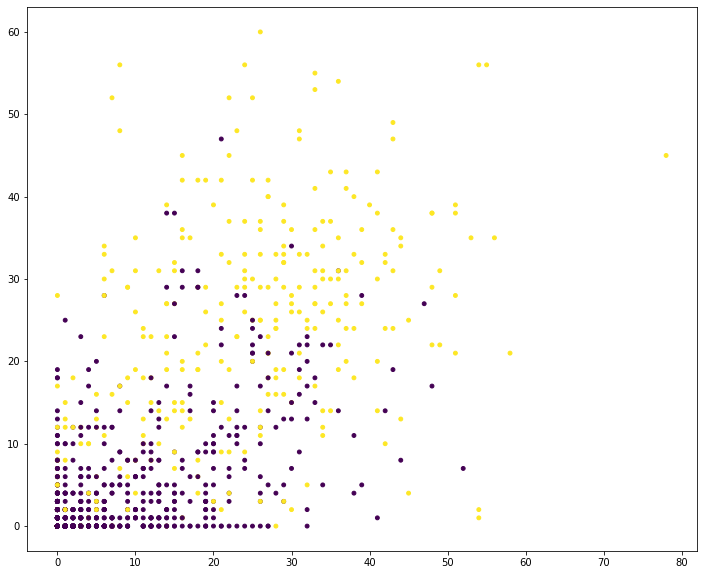

In [32]:
#true labels
plt.figure(figsize=(12,10))
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 2].values, c=test_label.values, s=15, cmap='viridis');

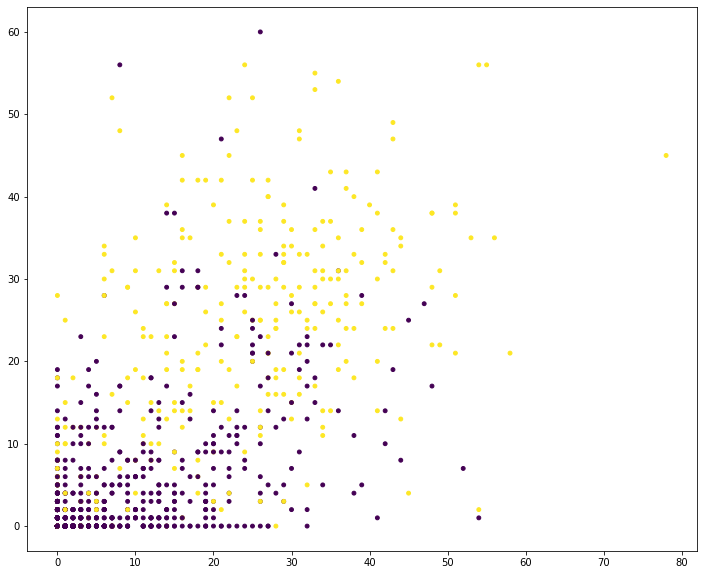

In [33]:
#predicted labels
plt.figure(figsize=(12,10))
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 2].values, c=test_pred_dt, s=15, cmap='viridis');

## Support Vector Machine #

Importing modules.

In [34]:
from sklearn.utils import resample #to downsample the dataset
from sklearn.preprocessing import scale #Scale the dataset
from sklearn.svm import SVC #Support vector machine for classification
from sklearn.model_selection import GridSearchCV #Cross validation
from sklearn.metrics import confusion_matrix #Create Confusion Matrix
from sklearn.metrics import plot_confusion_matrix #Draws a Confusion Matrix
from sklearn.decomposition import PCA #to perform PCA to plot data
import matplotlib.colors as colors

As we can see, the points in the scattered graph are not correctly divided. It means that the __Support Vector Machine__ might have some difficulties to find a correct __hyperplane__ (even the data dimensionality is not very high).

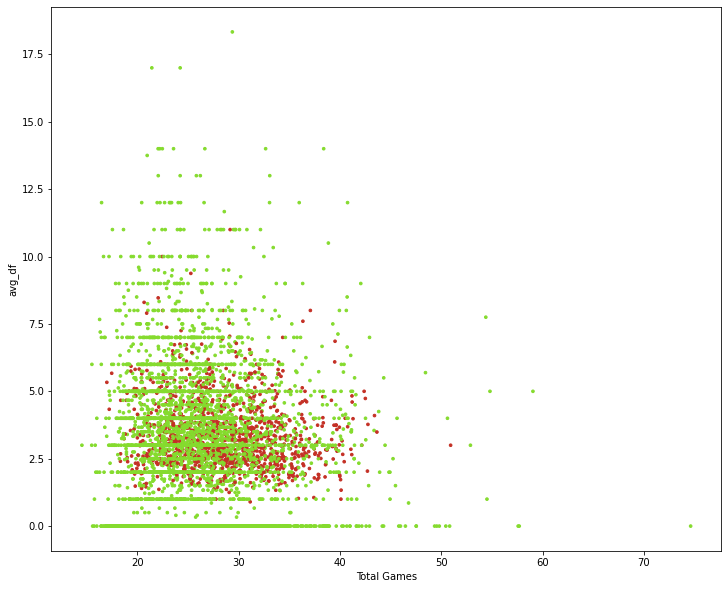

In [35]:
from sklearn.datasets import make_blobs

df_profile_clone = df_copy

plt.figure(figsize=(12,10))
cmap = colors.ListedColormap(['#85db2e', '#c43025'])
plt.scatter(df_profile_clone['01/09/2021_age'].values, df_profile_clone['avg_df'].values, c=df_profile_clone['label'].values, s=7, cmap=cmap)
plt.xlabel("Total Games")
plt.ylabel("avg_df")
plt.show()

In [36]:
df_profile_clone.dtypes

16/17_wins           int64
17/18_wins           int64
18/19_wins           int64
19/20_wins           int64
20/21_wins           int64
21/22_wins           int64
ace                  int64
svpt                 int64
ace_per_svpt       float64
first_serv_rt      float64
avg_df             float64
01/09/2021_age     float64
perc_bs            float64
highest_scr          int64
avg_scr            float64
SvGms              float64
fvrt_level_num       int64
player_hand_num      int64
mc_entry_num         int64
label                int64
dtype: object

## A first Support Vector Machine ##

Now let's do a first __Support Vector Machine__.

In [37]:
X = df_profile_clone.drop(['label'], axis=1).copy()
Y = df_profile_clone['label'].copy()

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)
X_train_scaled = scale(X_train)
X_test_scaled = scale (X_test)

We are finding the best values for the __Support Vector Machine__ using the __GridSearch__.

In [39]:
par_values = [
    {'C': [0.5, 1, 10, 100], #C must be greater than 0
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']}, #Radial basis function
] #C = 1 and gamma = 'scale' are the default parameters

optimal_par = GridSearchCV(
    SVC(),
    par_values,
    cv=3,
    scoring='accuracy',
    verbose=0
)

optimal_par.fit(X_train_scaled, Y_train)
print(optimal_par.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [40]:
clf_svm = SVC(C=100, gamma=0.01, kernel='rbf', random_state=1)
clf_svm.fit(X_train_scaled, Y_train)

SVC(C=100, gamma=0.01, random_state=1)

These results of the __Support Vector Machine__ are pretty good, but we will try to improve them by downsampling the dataset. Indeed the __Support Vector Machine__ is more precise in finding the best hyperplane when the points are few.

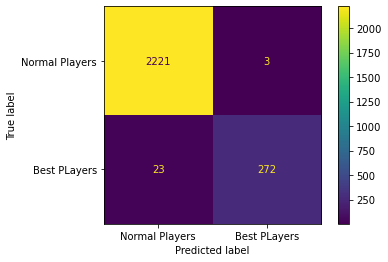

In [41]:
plot_confusion_matrix(clf_svm,
                      X_test_scaled,
                      Y_test,
                      values_format='d',
                      display_labels=['Normal Players', 'Best PLayers'])
plt.show()

## Downsample the data ##

__Support Vector Machines__ is optimal with small datasets. Our dataset is not big (it contains about 10.000 rows). We will try to downsample the dataset to improve our results.

In [42]:
len(df_profile_clone)

10074

Let's create two dataframes; one for the best players in the dataframe (__label__ = 1) and one for the other players (__label__ = 0). 

In [43]:
df_best_players = df_profile_clone[df_profile_clone['label'] == 1]
df_normal_players = df_profile_clone[df_profile_clone['label'] == 0]

Now we are going to take 500 rows for each category.

In [44]:
df_best_players_ds = resample(df_best_players,
                              replace=False,
                              n_samples=500,
                              random_state=1)

df_normal_players_ds = resample(df_normal_players,
                              replace=False,
                              n_samples=2000,
                              random_state=1)

Now we can merge the two dataframes.

In [45]:
df_profile_downsample = pd.concat([df_best_players_ds, df_normal_players_ds])

Now we are going to predict the class of each row using the other columns

Firstly we delete all the columns that we used to compute the class. These were __first_serv_rt__, __fvrt_level__, __perc_bs__, __highest_scr__, __avg_scr__. (It would be too esay for the algorithm to guess the correct label if we leave the attributes that we used to compute that labels.)

In [46]:
df_profile_downsample = df_profile_downsample.drop(['first_serv_rt', 'fvrt_level_num', 'perc_bs', 'highest_scr', 'avg_scr'], axis=1)

Now we split the dataframes into two dataframes:

__X__ will contain the attributes that we want to use to predict the class.\
__Y__ will contain the attributes that we want to predict (in this case the attribute __label__).

In [47]:
X = df_profile_downsample.drop(['label'], axis=1).copy()
Y = df_profile_downsample['label'].copy()

## Scaling and centering ##

__Support Vector Machine__ needs that the data is scaled and centered. In other words, we need a mean value of 0 and a standard deviation of 1. We have to do it to both the training set and the test set.

Firstly we split the dataset into the training set and the test set.

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)
X_train_scaled = scale(X_train)
X_test_scaled = scale (X_test)

## Build a preliminary Support Vector Machine ##

Now we are using the data created to perform a preliminary __Support Vector Machine__.

In [49]:
clf_svm = SVC(random_state=1)
clf_svm.fit(X_train_scaled, Y_train)

SVC(random_state=1)

Now we can plot the __confusion matrix__.

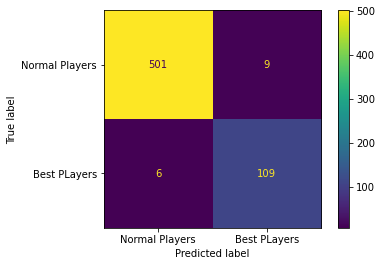

In [50]:
plot_confusion_matrix(clf_svm,
                      X_test_scaled,
                      Y_test,
                      values_format='d',
                      display_labels=['Normal Players', 'Best PLayers'])
plt.show()

As we can see the results were very precise, now we are going to improve these results by finding the best parameters for the __Support Vector Machine__.

## Optimization ##

We are going to optimize the algorithm finding the best values for the parameters __C__ and __gamma__.

__C__: trades off misclassification of training examples against simplicity of the decision surface. (default C=1)\
__gamma__: defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected. (default gamma='scale')

We are going to find the values for these parameters using __GridSearchCV()__ specifying some possible values for the parameters at this function.

Below we printed the optimal values.

In [51]:
par_values = [
    {'C': [0.5, 1, 10, 100], #C must be greater than 0
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']}, #Radial basis function
] #C = 1 and gamma = 'scale' are the default parameters

optimal_par = GridSearchCV(
    SVC(),
    par_values,
    cv=5,
    scoring='accuracy',
    verbose=0
)

optimal_par.fit(X_train_scaled, Y_train)
print(optimal_par.best_params_)

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Since the __Grid Search__ highlighted that the best values for the __Support Vector Machine__ are the default ones, we did not recompute the __Support Vector Machine__ with the optimized values.

## Recomputing the Support Vector Machine on the whole dataset ##

Now we are going to apply the __Support Vector Machine__ to the whole dataset, to check if we have improved the results thanks to the downsampling of the original dataset.

In [54]:
def search(list, platform):
    for i in range(len(list)):
        if list[i] == platform:
            return True
    return False

positions = []
for index, rows in df_profile_downsample.iterrows():
    positions.append(index)

df_svm = df_profile_clone.copy()
df_svm = df_svm.drop(['highest_scr', 'avg_scr', 'perc_bs', 'first_serv_rt', 'fvrt_level_num'], axis=1)
for index, rows in df_svm.iterrows():
    if search(positions, index):
        df_svm.drop(index, inplace=True)
        
len(df_svm)

7574

In [55]:
X_complete = df_svm.drop(['label'], axis=1).copy()
Y_complete = df_svm['label'].copy()

X_complete_scaled = scale(X_complete)

Surprisingly, the results after the downsample are quite poor. Hence, in our dataset, is better to compute the __Support Vector Machine__ on the whole dataset rather than on a subset of it.

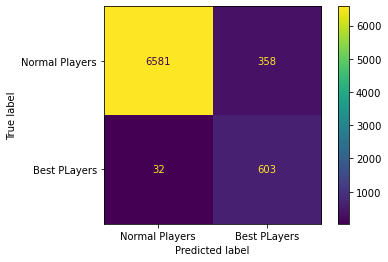

In [56]:
plot_confusion_matrix(clf_svm,
                      X_complete_scaled,
                      Y_complete,
                      values_format='d',
                      display_labels=['Normal Players', 'Best PLayers'])
plt.show()

## Principal Component Analysis ##

We are going to use the __PCA__ to combine all the features of our dataframe into only 2 axes

After that, we will check if the results improve using the __PCA__.

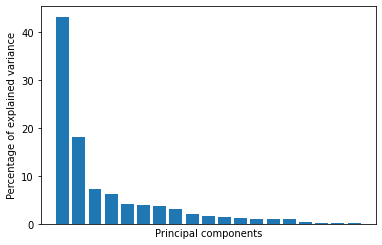

In [93]:
X = df_profile_clone.drop(['label'], axis=1).copy()
Y = df_profile_clone['label'].copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)
X_train_scaled = scale(X_train)
X_test_scaled = scale (X_test)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal components')
plt.show()

The more the two first columns are higher than the others, the more accurate is the approximation of __PCA__, in this case, the second column is not significantly higher than the third one, hence the approximation is not very accurate.

In [94]:
#training set
train_pc1_coords = X_train_pca[:,0] #the two coordinates of the data after PCA (x axis)
train_pc2_coords = X_train_pca[:,1] #(y axis)

#test set
test_pc1_coords = X_test_pca[:,0]
test_pc2_coords = X_test_pca[:,1]

pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))
pca_test_scaled = scale(np.column_stack((test_pc1_coords, test_pc2_coords)))
#Optimizing

par_values = [
    {'C': [1, 10, 100, 1000],
     'gamma': ['scale', 1, 0.1, 0.01, 0.001],
     'kernel': ['rbf']
    },
]

optimal_par = GridSearchCV(
    SVC(),
    par_values,
    cv=5,
    scoring='accuracy',
    verbose=0,
)

optimal_par.fit(pca_train_scaled, Y_train)
print(optimal_par.best_params_)

{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


Now we can use these optimal values that we found to compute the __Support Vector Machine__ one last time.

In [95]:
clf_svm = SVC(random_state=1, C=100, gamma='scale', kernel='rbf')
clf_svm.fit(pca_train_scaled, Y_train)

SVC(C=100, random_state=1)

With the __PCA__ approximation, the results were a little less precise, so 

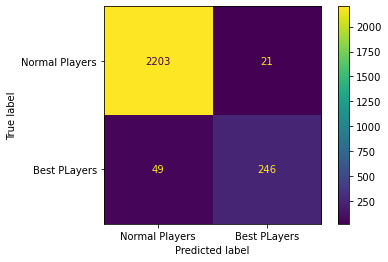

In [96]:
plot_confusion_matrix(clf_svm,
                    pca_test_scaled,
                      Y_test,
                      values_format='d',
                      display_labels=['Normal Players', 'Best PLayers'])
plt.show()

Below, we can see the final results for the __Support Vector Machine__.

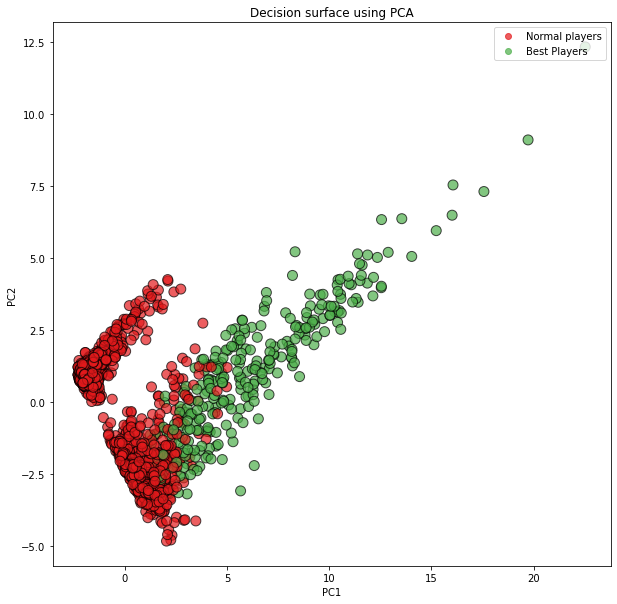

In [100]:
X_min = test_pc1_coords.min() - 1
X_max = test_pc1_coords.max() + 1

Y_min = test_pc2_coords.min() - 1
Y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=X_min, stop=X_max, step=0.1),
                    np.arange(start=Y_min, stop=Y_max, step=0.1))

#Classifying every points with the SVM

Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

#Now every value of 0 and 1 will be assigned to a point of the mesh

Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))

#create custom colors for the actual data points

cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

#plotting
scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=Y_test,
                    cmap=cmap,
                    s=100,
                    edgecolors='k',
                    alpha=0.7)

#creating a legend
legend = ax.legend(scatter.legend_elements()[0],
                  scatter.legend_elements()[1],
                  loc='upper right')
legend.get_texts()[0].set_text('Normal players')
legend.get_texts()[1].set_text('Best Players')

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision surface using PCA')
plt.show()

However the results achieved using the __PCA__ method are less precise (even if the confusion matrix suggests that there is not a great difference between them).

## Neural Network ##

We'll use tensorflow as our library to build and test the neural networks

In [62]:
import tensorflow as tf

2022-01-02 15:01:07.599324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-02 15:01:07.599374: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We're in the realm of supervised learning. We need the already computed labels to train the algorithm. We'll extract them from the dataframe and save them in another data structure

In [63]:
df_profile_nn = df_profile_clone.copy()

In [64]:
begone = ['first_serv_rt', 'fvrt_level_num', 'perc_bs', 'highest_scr', 'avg_scr', 'label']
df_profile_nn.drop(columns=begone, inplace=True)

We also need to transform the resulting dataset (10074 rows × 9 columns) in a tensor, since tensorflow need data arranged that way to work correctly.

In [65]:
numeric_features = np.array(df_profile_nn)

Let's break down the split.

We start with 10074 records.

Train/test split: 70/30, resulting in 7051/3023 records.

Then we further split the training set to obtain a validation set, this time 80/20: 5640/1411 records.

stratify=target ensures us that the unbalance in the label distribution will be kept.

In [66]:
from sklearn.model_selection import train_test_split

train_set, test_set, train_label, test_label = train_test_split(numeric_features, label, stratify=label, test_size=0.30)

Let's look at the distribution of the labels.

In [67]:
label.value_counts(True)

0    0.887334
1    0.112666
Name: label, dtype: float64

And let's check if the stratification worked.

In [68]:
train_label.value_counts(True)

0    0.887392
1    0.112608
Name: label, dtype: float64

Now we split the original dataset in train, validation and testing.

In [69]:
x_train = train_set[:5640]
y_train = train_label[:5640]

x_val = train_set[5640:] #1411
y_val = train_label[5640:]

x_test = test_set
y_test = test_label

We define a function that fits a standard scaler on the training set and applies it to all the dataset...

In [70]:
from sklearn.preprocessing import StandardScaler

def standardization(train, val, test):
    sc = StandardScaler()
    sc.fit(train)
    train_set_std = sc.transform(train)
    val_set_std = sc.transform(val)
    test_set_std = sc.transform(test)
    return train_set_std, val_set_std, test_set_std

... and we apply it.

In [71]:
x_train, x_val, x_test = standardization(x_train, x_val, x_test)

The code below is necessary to standardize the dataset we passed to the grid search to find the best hyper-parameters.

#sc2 = StandardScaler()
#sc2.fit(train_set)
#train_set = sc2.transform(train_set)

The original dataset we already split needs to be in tensor form:

In [72]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1])) #5640
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))

x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1])) #1411x1x9
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))

x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

#train_set = np.reshape(train_set, (train_set.shape[0], 1, train_set.shape[1]))
#train_label = np.asarray(train_label).astype('float32').reshape((-1,1))

Now we define the neural network model we'll use.

It is a standard perceptron with an added dropout layer at the topmost (to improve the generalization capability) and a dense layer of neurons with a ReLU activation.

The output layer is a single classifier that outputs values between 0 and 1 (thanks to the sigmoid activation function).

We decided to use the Stochastic Gradient Descent as the optimization algorithm since the learning task shouldn't bee too difficult and it lets us select the best learning rate and the best momentum.

We chose the binary_crossentropy as our loss: it computes the cross-entropy loss between true labels and predicted labels. 

This loss is used when there are only two label classes (assumed to be 0 and 1). 

For each example, there should be a single floating-point value per prediction.

In [73]:
from tensorflow.keras import optimizers

def create_model(learning_rate=0.01, m=0.001, neurons=8):
    model1 = tf.keras.models.Sequential([  
        tf.keras.layers.Flatten(input_shape=(1, 14)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(neurons, activation='relu'),  
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    opt = optimizers.SGD(learning_rate=learning_rate, momentum=m)

    model1.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    return model1

Below we comment off the code we used to search the best hyper-parameters (a grid search with a cross validation with 3 folds).

It is important to note that we don't split the training set in train+val because the GridSearchCV function takes care of it (and that's why we previously standardizet the commented variable train_set).

In [74]:
#from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier

#batch_size = [8, 12]
#epochs = [40, 60]
#learning_rate = [0.01, 0.03]
#neurons = [8, 13]

#param_grid = dict(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate, neurons=neurons)

#wrapped_model = KerasClassifier(build_fn=create_model)

#grid = GridSearchCV(estimator=wrapped_model, param_grid=param_grid, n_jobs=1, cv=3, scoring='f1', verbose=3)
#grid_result = grid.fit(train_set, train_label)

In [75]:
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [76]:
#df_result = pd.DataFrame(grid_result.cv_results_)
#df_result

Here we train the model on the training data (5640 records) holding out the validation with the hyper-parameter selection resulting from the grid search.

In [77]:
model1 = create_model()

history = model1.fit(x_train, y_train,
                    epochs=40,
                    batch_size=12,
                    validation_data=(x_val, y_val)
                    )

2022-01-02 15:01:09.394897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-02 15:01:09.394920: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-02 15:01:09.394939: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (carlo-Aspire-A515-52G): /proc/driver/nvidia/version does not exist
2022-01-02 15:01:09.395171: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
470/470 [==============================] - 1s 977us/step - loss: 0.3779 - binary_accuracy: 0.8663 - val_loss: 0.1790 - val_binary_accuracy: 0.9539
Epoch 2/40
470/470 [==============================] - 0s 845us/step - loss: 0.1495 - binary_accuracy: 0.9530 - val_loss: 0.1270 - val_binary_accuracy: 0.9568
Epoch 3/40
470/470 [==============================] - 0s 881us/step - loss: 0.1193 - binary_accuracy: 0.9569 - val_loss: 0.1117 - val_binary_accuracy: 0.9575
Epoch 4/40
470/470 [==============================] - 0s 928us/step - loss: 0.1050 - binary_accuracy: 0.9599 - val_loss: 0.1042 - val_binary_accuracy: 0.9568
Epoch 5/40
470/470 [==============================] - 0s 947us/step - loss: 0.1014 - binary_accuracy: 0.9612 - val_loss: 0.1003 - val_binary_accuracy: 0.9554
Epoch 6/40
470/470 [==============================] - 0s 938us/step - loss: 0.0940 - binary_accuracy: 0.9642 - val_loss: 0.0974 - val_binary_accuracy: 0.9561
Epoch 7/40
470/470 [==============================] 

In [78]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 8)                 120       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


Let's look at how the Loss and the Accuracy vary wrt the epochs.

From this plot we can see that there is no overfitting and that the Loss flows rather smoothly.

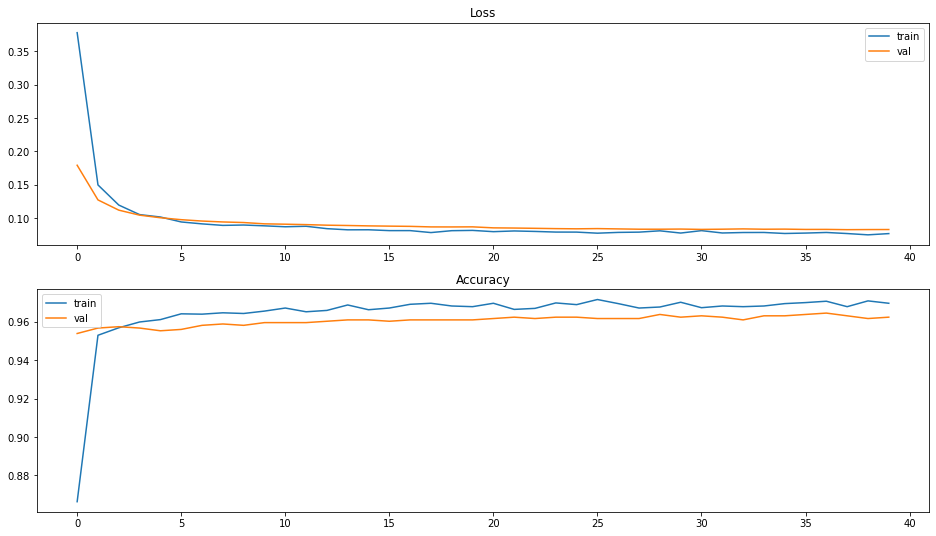

In [79]:
fig, axs = plt.subplots(2,1,figsize=(16,9))

axs[0].set_title('Loss')
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.history['binary_accuracy'], label='train')
axs[1].plot(history.history['val_binary_accuracy'], label='val')
axs[1].legend()

#TODO 
# add test too after model selection

The prediction output is a floating point number between 0 and 1. 

We use 0.5 as the threshold to assign it to one of the two possible labels.

In [80]:
y_train_pred_float = model1.predict(x_train)
y_train_pred_round = (y_train_pred_float > 0.5).astype("int32")

In [81]:
y_pred_float = model1.predict(x_test)
y_pred_round = (y_pred_float > 0.5).astype("int32")

We can check the accuracy scores on the splitted dataset, which we'll be part of the classification report later.

In [82]:
_, train_acc = model1.evaluate(x_train, y_train, verbose=0)
_, val_acc   = model1.evaluate(x_val, y_val, verbose=0)
_, test_acc  = model1.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f\nVal:   %.3f\nTest:  %.3f' % (train_acc, val_acc, test_acc))

Train: 0.973
Val:   0.962
Test:  0.975


Now we can look at the classification report and at the confusion matrix both for the training and the testing set.

In [83]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_pred_round))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      5007
         1.0       0.89      0.87      0.88       633

    accuracy                           0.97      5640
   macro avg       0.93      0.93      0.93      5640
weighted avg       0.97      0.97      0.97      5640



In [84]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_round))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      2682
         1.0       0.88      0.90      0.89       341

    accuracy                           0.97      3023
   macro avg       0.93      0.94      0.94      3023
weighted avg       0.98      0.97      0.97      3023



In [85]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

train_cm = confusion_matrix(y_train, y_train_pred_round)
print(train_cm)

[[4936   71]
 [  81  552]]


In [86]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_round))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      2682
         1.0       0.88      0.90      0.89       341

    accuracy                           0.97      3023
   macro avg       0.93      0.94      0.94      3023
weighted avg       0.98      0.97      0.97      3023



In [87]:
test_cm = confusion_matrix(y_test, y_pred_round)
print(test_cm)

[[2640   42]
 [  34  307]]


All of the three methods we investigated reported good results, both on the 'low ranked' (0) and on the 'high ranked' (1) labels.

We achieved a 0.98 f1-score for the 'low ranked' (0) label computed by all methods, except for the Optimized SVM which achieved a slightly lower 0.95. A value this high can be explained by the imbalanced dataset (in favor of label 0, which constituted of almost 90% of all records) and by the easy labelling function. 

The 'high ranked' (1) label prediction had a similar behaviour, with three methods (Random DT, Best DT, SVM) achieving the value of 0.87 and the other two methods surpassing it: the perceptron yielded us a 0.89 score, while the Optimized SVM won the contest with the highest value of 0.95. We think that the latter method was helped by the copious amount of preprocessing that went into its construction: both the downsampling and the deep grid search allowed the SVM to learn the differences between the low ranked and the high ranked players.

Another notable result was the constant higher recall value (over the precision) for the 'high ranked' label for all methods except the Best DT. All in all, we would have preferred the opposite behaviour: with a lower precision we are misclassifying bad players as good, which in a real world scenario could result in inviting bad players in extremely demanding tournaments, possibly jeopardizing their careers and/or sponsors opportunities. Our result (high recall) instead pushes us toward inviting many players, which could be good if the "overall invitation cost" (both for an abstract inviting entity that spends money and for the invitees that waeg their reputation) is low, paving the way to discovering new promising players.